In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# enrichment_file = "fgsea"
enrichment_file = "gprofiler"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    # Acutally, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results. 
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

In [73]:
# enr = enr[enr["source"] == "GO:MF"] # Molecular function
# enr = enr[enr["source"] == "GO:CC"] # Cellular component
enr = enr[enr["source"] == "GO:BP"] # Biological process
# enr = enr[enr["source"] == "KEGG"] # KEGG pathways
# enr = enr[enr["source"] == "REAC"] # Reactome pathways

In [74]:
enr = enr[enr["p_value"] < .05]

In [75]:
enr["minlogp"] = -np.log10(enr["p_value"])

In [76]:
enr.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,method,dim,minlogp
0,GO:BP,GO:0048583,regulation of response to stimulus,1.068798e-12,True,"""Any process that modulates the frequency, rat...",3231,169,81,16121,0.479290,0.025070,mofa 9,"['GO:0050789', 'GO:0050896']",mofa,9,11.971104
1,GO:BP,GO:0048583,regulation of response to stimulus,4.129373e-11,True,"""Any process that modulates the frequency, rat...",3231,159,75,16121,0.471698,0.023213,mofa 12,"['GO:0050789', 'GO:0050896']",mofa,12,10.384116
2,GO:BP,GO:0023052,signaling,5.416447e-11,True,"""The entirety of a process in which informatio...",5119,169,102,16121,0.603550,0.019926,mofa 9,['GO:0008150'],mofa,9,10.266285
3,GO:BP,GO:0007165,signal transduction,6.514975e-11,True,"""The cellular process in which a signal is con...",4712,169,97,16121,0.573964,0.020586,mofa 9,"['GO:0007154', 'GO:0009987', 'GO:0023052', 'GO...",mofa,9,10.186087
4,GO:BP,GO:0007154,cell communication,8.615173e-11,True,"""Any process that mediates interactions betwee...",5152,169,102,16121,0.603550,0.019798,mofa 9,['GO:0009987'],mofa,9,10.064736


## Count enrichments

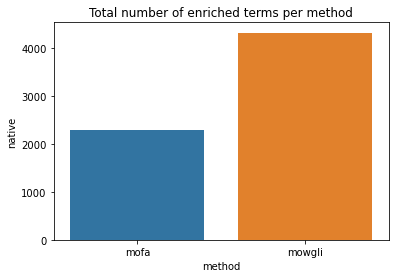

In [77]:
plt.title("Total number of enriched terms per method")
sns.barplot(data=enr.groupby("method").count().reset_index(), x="method", y="native")
plt.show()

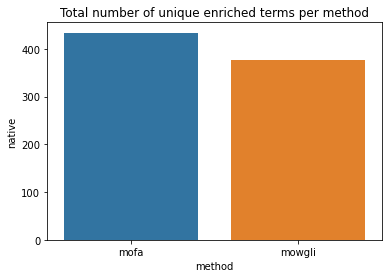

In [78]:
plt.title("Total number of unique enriched terms per method")
sns.barplot(data=enr.groupby("method")["native"].nunique().reset_index(), x="method", y="native")
plt.show()

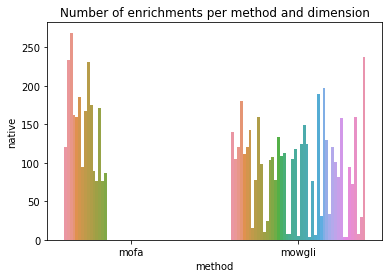

In [79]:
fig, ax = plt.subplots(1, 1)
sns.barplot(data=enr.groupby(["method", "dim"])["native"].count().reset_index(), x="method", y="native", hue="dim", ax=ax)
ax.get_legend().remove()
ax.set_title("Number of enrichments per method and dimension")
plt.show()

## Check specificity

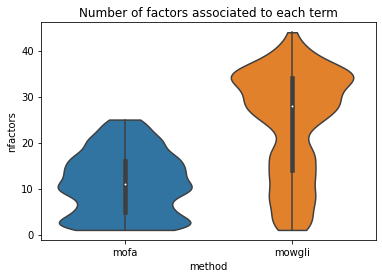

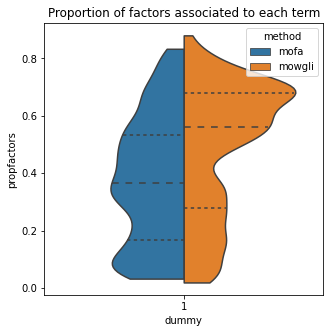

In [80]:
enr["nfactors"] = 0
nfactors = enr.groupby(["native", "method"])["native"].count()
enr.set_index(["native", "method"], inplace=True)
enr.loc[nfactors.index, "nfactors"] = nfactors
enr.reset_index(inplace=True)

plt.title("Number of factors associated to each term")
sns.violinplot(data=enr, x="method", y="nfactors", cut=0)
plt.show()

enr["ndim"] = 0
enr.loc[enr["method"] == "mofa", "ndim"] = 30
enr.loc[enr["method"] == "mowgli", "ndim"] = 50
enr["propfactors"] = enr["nfactors"] / enr["ndim"]
enr["dummy"] = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Proportion of factors associated to each term")
sns.violinplot(
    data=enr,
    x="dummy",
    hue="method",
    y="propfactors",
    split=True,
    ax=ax,
    inner="quart",
    cut=0,
)
plt.show()


In [81]:
selectivity_mofa = (enr[enr["method"] == "mofa"]["native"].nunique() + 30) / (2*enr[enr["method"] == "mofa"]["native"].count())
selectivity_mowgli = (enr[enr["method"] == "mowgli"]["native"].nunique() + 50) / (2*enr[enr["method"] == "mowgli"]["native"].count())
print("Selectivity of MOFA+: {:.4f}".format(selectivity_mofa))
print("Selectivity of Mowgli: {:.4f}".format(selectivity_mowgli))

Selectivity of MOFA+: 0.1010
Selectivity of Mowgli: 0.0493


## Biology-driven check

In [82]:
enr.head()

,native,method,source,name,p_value,significant,description,term_size,query_size,intersection_size,...,precision,recall,query,parents,dim,minlogp,nfactors,ndim,propfactors,dummy
0,GO:0048583,mofa,GO:BP,regulation of response to stimulus,1.068798e-12,True,"""Any process that modulates the frequency, rat...",3231,169,81,...,0.479290,0.025070,mofa 9,"['GO:0050789', 'GO:0050896']",9,11.971104,25,30,0.833333,1
1,GO:0048583,mofa,GO:BP,regulation of response to stimulus,4.129373e-11,True,"""Any process that modulates the frequency, rat...",3231,159,75,...,0.471698,0.023213,mofa 12,"['GO:0050789', 'GO:0050896']",12,10.384116,25,30,0.833333,1
2,GO:0023052,mofa,GO:BP,signaling,5.416447e-11,True,"""The entirety of a process in which informatio...",5119,169,102,...,0.603550,0.019926,mofa 9,['GO:0008150'],9,10.266285,23,30,0.766667,1
3,GO:0007165,mofa,GO:BP,signal transduction,6.514975e-11,True,"""The cellular process in which a signal is con...",4712,169,97,...,0.573964,0.020586,mofa 9,"['GO:0007154', 'GO:0009987', 'GO:0023052', 'GO...",9,10.186087,25,30,0.833333,1
4,GO:0007154,mofa,GO:BP,cell communication,8.615173e-11,True,"""Any process that mediates interactions betwee...",5152,169,102,...,0.603550,0.019798,mofa 9,['GO:0009987'],9,10.064736,24,30,0.800000,1


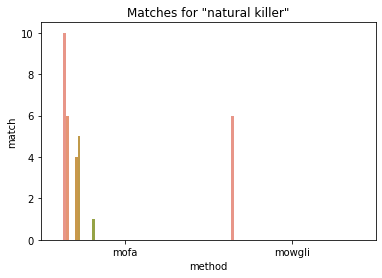

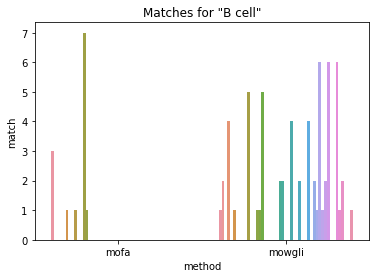

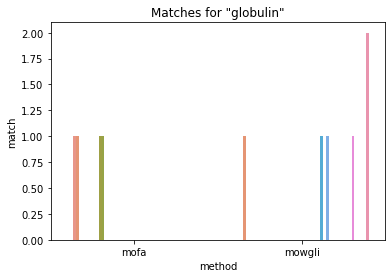

In [90]:
def barplot_matches(keywords, case=False):
    enr["match"] = enr["name"].str.contains(keywords, case=case)
    fig, ax = plt.subplots(1, 1)
    sns.barplot(
        data=enr.groupby(["method", "dim"])["match"].sum().reset_index(),
        x="method",
        y="match",
        hue="dim",
        ax=ax,
    )
    ax.set_title(f'Matches for "{keywords}"')
    ax.get_legend().remove()
    plt.show()


barplot_matches("natural killer")
barplot_matches("B cell")
barplot_matches("globulin")


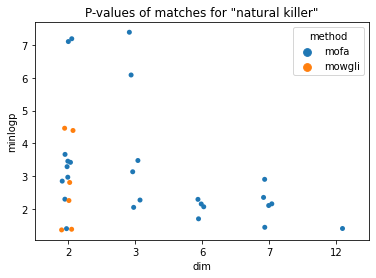

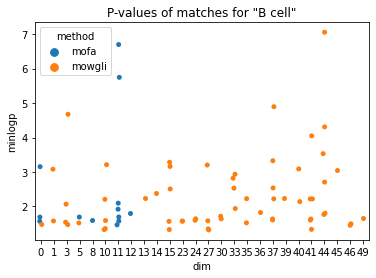

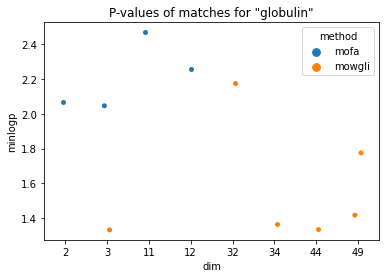

In [91]:
def stripplot_matches(keywords, case=False):
    fig, ax = plt.subplots(1, 1)
    sns.stripplot(
        data=enr[enr["name"].str.contains(keywords, case=case)],
        x="dim",
        y="minlogp",
        hue="method",
    )
    ax.set_title(f"P-values of matches for \"{keywords}\"")
    plt.show()

stripplot_matches("natural killer")
stripplot_matches("B cell")
stripplot_matches("globulin")